## Train image classifier on dogs cats dataset

### Import libraries

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision

#######################################
### PRE-TRAINED MODELS AVAILABLE HERE
## https://pytorch.org/vision/stable/models.html
from torchvision import models
#######################################

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from PIL import Image

%matplotlib inline
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

### Setup log folder

In [2]:
EXPERIMENT_NAME = "convnet_dogscats" 
ROOT_DIR = os.path.abspath(".")
LOG_PATH = os.path.join(ROOT_DIR, "logs", EXPERIMENT_NAME)

if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
    os.mkdir(os.path.join(ROOT_DIR, "logs"))
    
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)

### Setup params

In [3]:
# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Architecture
NUM_CLASSES = 2

cuda:0


### Download data and setup path

In [4]:
# Setup training data
TRAIN_ROOT = './datasets/dogscats/train'
num_train_cats = len([i for i in os.listdir(os.path.join(TRAIN_ROOT, 'Cat')) 
                      if i.endswith('.jpg') and i.startswith('cat')])

num_train_dogs = len([i for i in os.listdir(os.path.join(TRAIN_ROOT, 'Dog')) 
                      if i.endswith('.jpg') and i.startswith('dog')])

print(f'Training set cats: {num_train_cats}')
print(f'Training set dogs: {num_train_dogs}')

# Setup validation data
VAL_ROOT = './datasets/dogscats/val'
num_train_cats = len([i for i in os.listdir(os.path.join(VAL_ROOT, 'Cat')) 
                      if i.endswith('.jpg') and i.startswith('cat')])

num_train_dogs = len([i for i in os.listdir(os.path.join(VAL_ROOT, 'Dog')) 
                      if i.endswith('.jpg') and i.startswith('dog')])

print(f'Validation set cats: {num_train_cats}')
print(f'Validation set dogs: {num_train_dogs}')

Training set cats: 936
Training set dogs: 936
Validation set cats: 168
Validation set dogs: 168


### Plot and image

(331, 464, 3)


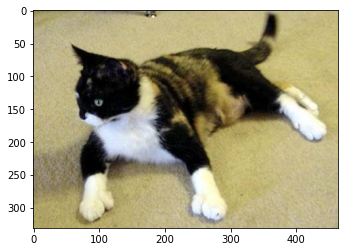

In [5]:
img = Image.open(os.path.join(TRAIN_ROOT, 'Cat', 'cat.59.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

(403, 499, 3)


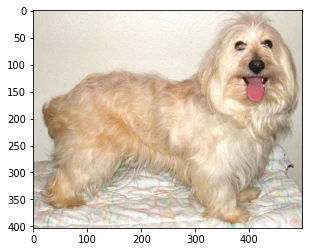

In [6]:
img = Image.open(os.path.join(TRAIN_ROOT, 'Dog', 'dog.23.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

### Define dataloader and transform


In [7]:
## setting directories
data_dir = './datasets/dogscats/'
train_dir = os.path.join(data_dir, 'train') 
val_dir = os.path.join(data_dir, 'val')

In [8]:
## transform
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # resize image
    transforms.CenterCrop((224, 224)), # center crop image
    transforms.ToTensor(), # convert to Pytorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = ImageFolder(train_dir, train_transforms)
val_dataset = ImageFolder(val_dir, val_transforms)
test_dataset = ImageFolder(val_dir, val_transforms) # note: val and test is same

print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(val_dataset)}')
print(f'Number of test examples: {len(test_dataset)}')

Number of training examples: 1872
Number of validation examples: 336
Number of test examples: 336


In [9]:
## layout of the dataset

print(train_dataset.class_to_idx)
print(val_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'Cat': 0, 'Dog': 1}
{'Cat': 0, 'Dog': 1}
{'Cat': 0, 'Dog': 1}


### Init Setup dataloader

In [10]:
# train loader and test loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True,
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          shuffle=False)

### Visualize data from data loader

In [11]:
def to_img(ten):
    # Un-normalize and convert to RGB format for visualization
    ten =(ten[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    ten=(ten*255).astype(np.uint8)
    return ten

In [12]:
cat = train_dataset[1] ## cat is tuple
dog = train_dataset[1500] ## dog is a tuple, dog[0] holds its image tensor

(224, 224, 3)


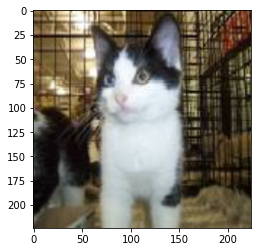

In [13]:
cat_image = to_img(cat)
print(cat_image.shape)
plt.imshow(cat_image)

(224, 224, 3)


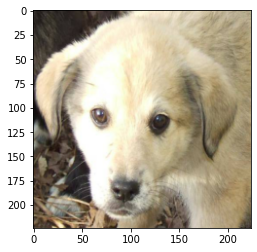

In [14]:
dog_image = to_img(dog)
print(dog_image.shape)
plt.imshow(dog_image)

### Define ConvNet model

In [15]:
def resnet18(num_classes):
        """Transfer learning with VGG16 pretrained on ImageNet dataset.

        Args:
            num_classes (int): number of classes

        Returns:
            _type_: model
        """
        
        # get pretrained model, VGG16 pre-trained on ImageNet
        model = models.vgg16(pretrained=True)

        # freeze whole model
        for param in model.parameters():
                param.requires_grad = False
                
        # replace last fc layer with new fc layer(s)
        model.classifier[-1] = nn.Sequential(
                        nn.Linear(4096, 512), 
                        nn.ReLU(), 
                        nn.Dropout(0.5),
                        nn.Linear(512, num_classes))
        return model

### Build model and define optimizer

In [16]:
torch.manual_seed(RANDOM_SEED)
model = resnet18(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Train

In [17]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        probas = F.softmax(logits, dim=1)

        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []
best_acc = 0

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING, every 100 batches
        if not batch_idx % 25: 
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, val_loader, device=DEVICE)
        
        #Save best model
        if valid_acc > best_acc:
            print("Saving model at accuracy={:.3f}".format(valid_acc))
            torch.save(model.state_dict(), '{}/{}.pth'.format(LOG_PATH, 'model'))
            best_acc = valid_acc
            
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/010 | Batch 000/014 | Cost: 0.7239
Saving model at accuracy=95.238
Epoch: 001/010 Train Acc.: 97.10% | Validation Acc.: 95.24%
Time elapsed: 0.25 min
Epoch: 002/010 | Batch 000/014 | Cost: 0.1115
Saving model at accuracy=97.024
Epoch: 002/010 Train Acc.: 97.88% | Validation Acc.: 97.02%
Time elapsed: 0.76 min
Epoch: 003/010 | Batch 000/014 | Cost: 0.1017
Saving model at accuracy=97.917
Epoch: 003/010 Train Acc.: 98.21% | Validation Acc.: 97.92%
Time elapsed: 1.13 min
Epoch: 004/010 | Batch 000/014 | Cost: 0.0699
Epoch: 004/010 Train Acc.: 98.60% | Validation Acc.: 97.92%
Time elapsed: 1.37 min
Epoch: 005/010 | Batch 000/014 | Cost: 0.0513
Saving model at accuracy=98.214
Epoch: 005/010 Train Acc.: 98.83% | Validation Acc.: 98.21%
Time elapsed: 1.75 min
Epoch: 006/010 | Batch 000/014 | Cost: 0.0374
Saving model at accuracy=98.512
Epoch: 006/010 Train Acc.: 98.88% | Validation Acc.: 98.51%
Time elapsed: 2.15 min
Epoch: 007/010 | Batch 000/014 | Cost: 0.0524
Epoch: 007/010 Train

### Plot loss and accuracy

In [18]:
new_train_acc_lst, new_valid_acc_lst = [], []
for i in train_acc_lst:
    i = i.cpu()
    new_train_acc_lst.append(i)
for l in valid_acc_lst:
    l = l.cpu()
    new_valid_acc_lst.append(l)

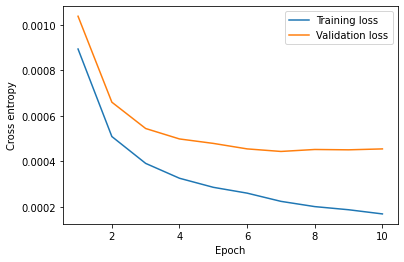

In [19]:
train_loss_lst = np.array(train_loss_lst)
np.savetxt("{}/{}_train_loss.txt".format(LOG_PATH, EXPERIMENT_NAME), train_loss_lst, delimiter=",")
valid_loss_lst = np.array(valid_loss_lst)
np.savetxt("{}/{}_valid_loss.txt".format(LOG_PATH, EXPERIMENT_NAME), valid_loss_lst, delimiter=",")

train_acc_lst = np.array(new_train_acc_lst)
np.savetxt("{}/{}_train_acc.txt".format(LOG_PATH, EXPERIMENT_NAME), train_acc_lst, delimiter=",")
valid_acc_lst = np.array(new_valid_acc_lst)
np.savetxt("{}/{}_valid_acc.txt".format(LOG_PATH, EXPERIMENT_NAME), valid_acc_lst, delimiter=",")

plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.savefig('{}/{}_loss_graph.png'.format(LOG_PATH, EXPERIMENT_NAME), dpi=300)
plt.show()

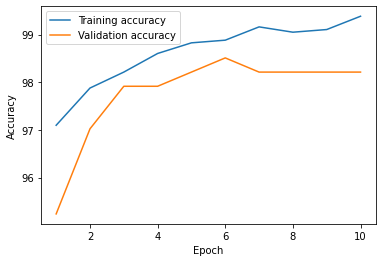

In [20]:
plt.plot(range(1, NUM_EPOCHS+1), new_train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), new_valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('{}/{}_acc_graph.png'.format(LOG_PATH, EXPERIMENT_NAME), dpi=300)
plt.show()

### Testing

In [21]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, val_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 98.21%


In [22]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
    
train_mean, train_std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

train_mean = torch.tensor(train_mean)
train_std = torch.tensor(train_std)

print(train_mean)
print(train_std)

unorm = UnNormalize(mean=train_mean, std=train_std)

tensor([0.5000, 0.5000, 0.5000])
tensor([0.5000, 0.5000, 0.5000])


### Visualize some predictions 

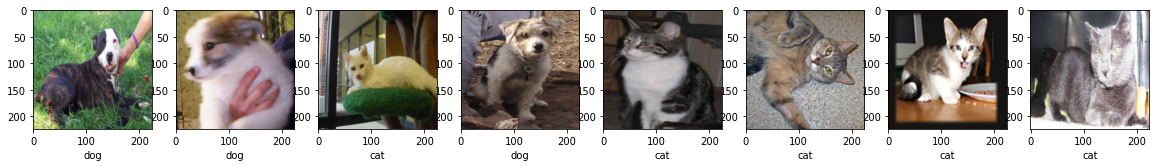

In [23]:
val_loader = DataLoader(dataset=train_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

for features, targets in val_loader:
    break
    

logits = model(features[:8].to(DEVICE))
probas = F.softmax(logits, dim=1)
predictions = torch.argmax(probas, dim=1)

d = {0: 'cat',
     1: 'dog'}
    
fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = unorm(features[i])
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()

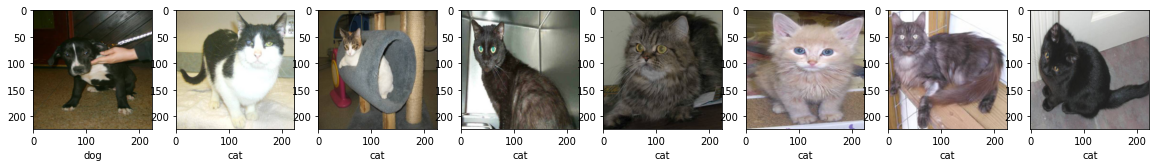

In [24]:
test_loader = DataLoader(dataset=val_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

logits = model(features[:8].to(DEVICE))
probas = F.softmax(logits, dim=1)
predictions = torch.argmax(probas, dim=1)

d = {0: 'cat',
     1: 'dog'}
    
fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = unorm(features[i])
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()

### Infer on one input image

In [25]:
# Load model
torch.manual_seed(RANDOM_SEED)
model_path = f'./logs/{EXPERIMENT_NAME}/model.pth'
model = resnet18(num_classes=NUM_CLASSES)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model = model.to(DEVICE)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
# Inference!
def inference(input_image_path):
    image = Image.open(input_image_path).convert("RGB")
    class_index = {0: 'cat', 1: 'dog'}

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # Move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        logits = model(input_batch)
        probas = F.softmax(logits, dim=1)
        
    predictions = torch.argmax(probas, dim=1)
    label = class_index[predictions.item()]
    return label

The predicted label is dog.
(375, 499, 3)


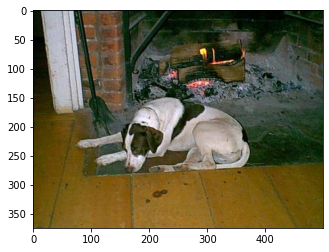

In [27]:
path_to_img = os.path.join(TRAIN_ROOT, 'Dog', 'dog.25.jpg')
#path_to_img = os.path.join(TRAIN_ROOT, 'Cat', 'cat.20.jpg')

prediction = inference(path_to_img)
print(f"The predicted label is {prediction}.")

img = Image.open(path_to_img)
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img)

### Evaluate on various metrics

In [28]:
print(len(test_dataset))
print(len(test_loader))
print(test_dataset.class_to_idx)

336
3
{'Cat': 0, 'Dog': 1}


In [29]:
def evaluation(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    predictions = []
    tgts = []
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        probas = F.softmax(logits, dim=1)
        
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        predicted_labels = predicted_labels.detach().cpu().numpy()
        predictions.extend(predicted_labels)
        targets = targets.detach().cpu().numpy()
        tgts.extend(targets)
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples, tgts, predictions

### Load best trained model

In [30]:
## load best model, this will be different from the previous test, as the model was from last checkpoint
## best and last checkpoints are different in this experiment.
torch.manual_seed(RANDOM_SEED)

model_path = f'./logs/{EXPERIMENT_NAME}/model.pth'
model = resnet18(num_classes=NUM_CLASSES)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model = model.to(DEVICE)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Get accuracy, precision, recall, AUC etc.

In [31]:
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss, y_true, y_pred = evaluation(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 98.51%


In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       168
           1       0.99      0.98      0.99       168

    accuracy                           0.99       336
   macro avg       0.99      0.99      0.99       336
weighted avg       0.99      0.99      0.99       336



In [33]:
print(f'area under roc curve = {roc_auc_score(y_true, y_pred)}')

area under roc curve = 0.9851190476190477


In [34]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f'TP = {tp}')
print(f'FN = {fn}')
print(f'FP = {fp}')
print(f'TN = {tn}')

sens = tp/(tp+fn) * 100 
specfs = tn/(tn+fp) * 100 

print(10*'=')
print(f'Sensitivity = {sens}%')
print(f'Specificity = {specfs}%')


TP = 165
FN = 3
FP = 2
TN = 166
Sensitivity = 98.21428571428571%
Specificity = 98.80952380952381%


In [35]:
print("Done!")

Done!
